# =============================
# Script 1 : pretrain_autoencoders.py
# =============================

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from data_loader_pretraining import RawDataLoader
from utils import DATA_MODALITIES, RAW_BOTH_DATA_FOLDER, BOTH_SCREENING_DATA_FOLDER, CCLE_RAW_DATA_FOLDER, CCLE_SCREENING_DATA_FOLDER, TCGA_DATA_FOLDER
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import random
import numpy as np


# Utiliser le GPU si dispo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
RANDOM_SEED=42

cpu


In [2]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(SimpleAutoencoder, self).__init__()
        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, latent_dim)
        )
        # Decoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, input_dim)
        )

    def forward(self, x, return_latent=False):
        z = self.encoder(x)
        decoded = self.decoder(z)
        if return_latent:
            return decoded, z
        else:
            return decoded

def train(model, train_loader, val_loader, epochs, alpha=1):

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-8)
    
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0.0

        for batch, data in enumerate(train_loader):
            data = data[0]
            recon = model(data)
            loss = weighted_mse_loss(recon, data, alpha)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_loss.append(total_train_loss / len(train_loader))

        # Validation
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for val_batch, val_data in enumerate(val_loader):
                val_data = val_data[0]
                val_recon = model(val_data)

                val_batch_loss = weighted_mse_loss(val_recon, val_data, alpha)
                total_val_loss += val_batch_loss.item()

        val_loss.append(total_val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")

    return train_loss, val_loss

def weighted_mse_loss(recon, target, alpha=1):
    """
    alpha > 1 => donne plus de poids aux non-zéros
    alpha = 1 => MSE classique
    """
    alpha = torch.tensor(alpha, dtype=target.dtype, device=target.device)
    one = torch.tensor(1.0, dtype=target.dtype, device=target.device)
    weight = torch.where(target != 0, alpha, one)
    loss = ((recon - target) ** 2 * weight).mean()
    return loss

def plot_tsne(X_tensor, title):
    np.random.seed(42) 
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_embedded = tsne.fit_transform(X_tensor)
    plt.figure(figsize=(7, 5))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=10, alpha=0.6)
    plt.title(title)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
def train_autoencoder(X_train, X_test, X_train_sizes, X_test_sizes, latent_dim, save_path, epochs=25, batch_size=64):
    
    model = SimpleAutoencoder(X_train.shape[1], latent_dim).to(device)

    # Convert training data and testing data to PyTorch tensors
    X_train_tensor = torch.Tensor(X_train.values)
    X_test_tensor = torch.Tensor(X_test.values)
    
    # normalize data
    X_train_tensor = torch.nn.functional.normalize(X_train_tensor, dim=0)
    X_test_tensor = torch.nn.functional.normalize(X_test_tensor, dim=0)

    # Create a TensorDataset with the input features
    train_dataset = TensorDataset(X_train_tensor.to(device))
    test_dataset = TensorDataset(X_test_tensor.to(device))
    
    # Create the train_loader and val_loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train the model
    train_loss, test_loss = train(model, train_loader, val_loader, epochs)

    torch.save(model.state_dict(), save_path)

    # Tracé de la courbe de loss
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
    plt.plot(range(1, epochs+1), test_loss, label='Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation AE Losses - {save_path}")
    plt.legend()
    plt.grid(True)
    #plt.ylim(0, 15) 
    plt.tight_layout()
    plt.show()
    
    return model

In [4]:
def cv_train_autoencoder(X_train, X_train_sizes, latent_dim, save_path, device, epochs=25, k=5, batch_size=64):

    splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)


    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(X_train)))):
        print('Fold {}'.format(fold + 1))

        
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        
        model = SimpleAutoencoder(X_train.shape[1], latent_dim)

        model = model.to(device)

        # Convert training data to PyTorch tensors
        X_train_tensor = torch.Tensor(X_train.values).to(device)

        # Create a TensorDataset with the input features and target labels
        train_dataset = TensorDataset(X_train_tensor)

        # Create the train_loader and test_loader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        test_loader = DataLoader(train_dataset, batch_size=len(X_train), sampler=test_sampler)
        
        # Train the model
        train_loss, val_loss = train(model, train_loader, test_loader, epochs, alpha=1)

        torch.save(model.state_dict(), save_path)

        # Tracé de la courbe de loss
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
        plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Training and Validation AE Losses - {save_path}")
        plt.legend()
        plt.grid(True)
        #plt.ylim(0, 15) 
        plt.tight_layout()
        plt.show()

    return model

Reading Raw Data Files...:   0%|                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  33%|███████████████████                                      | 2/6 [00:59<01:58, 29.60s/it]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  50%|████████████████████████████▌            

dict_keys(['cell_exp', 'cell_mut', 'drug_desc', 'drug_finger'])
cell_exp: (1355, 19221)
cell_mut: (1355, 17671)
drug_desc: (704, 209)
drug_finger: (704, 4048)
x_cell_train shape: (1355, 36892)
x_drug_train shape: (704, 4257)
X_cell_train sparsity: 0.5275619310459613
X_drug_train sparsity: 0.7041123443739723


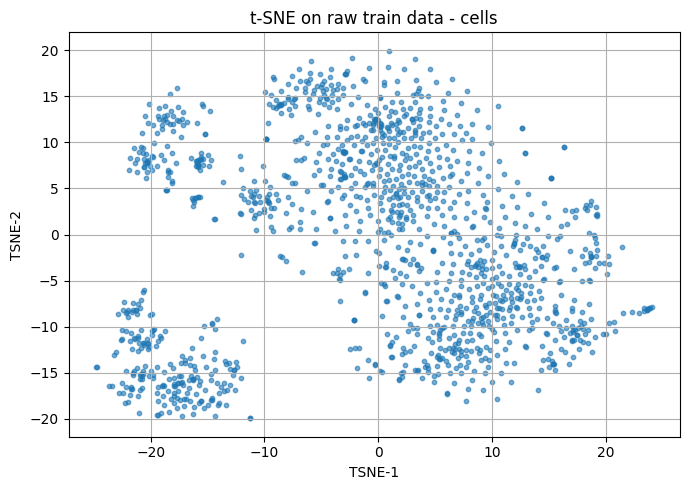

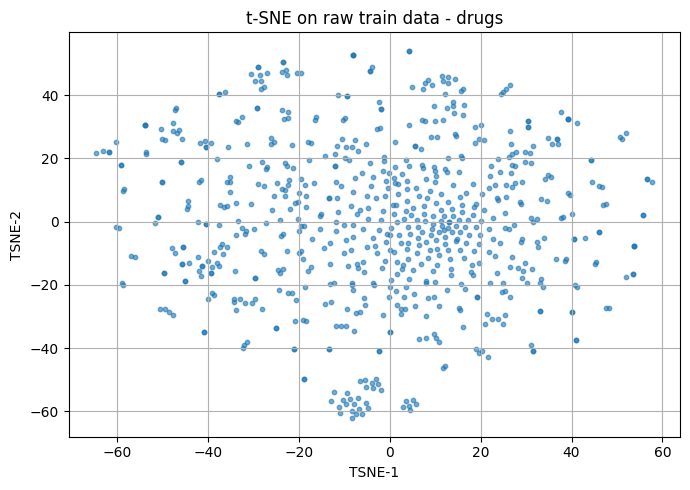

Run 0
Fold 1
Epoch [1/25], Train Loss: 0.1247, Val Loss: 0.0625
Epoch [2/25], Train Loss: 0.0554, Val Loss: 0.0580
Epoch [3/25], Train Loss: 0.0493, Val Loss: 0.0478
Epoch [4/25], Train Loss: 0.0455, Val Loss: 0.0451
Epoch [5/25], Train Loss: 0.0434, Val Loss: 0.0422
Epoch [6/25], Train Loss: 0.0415, Val Loss: 0.0411
Epoch [7/25], Train Loss: 0.0408, Val Loss: 0.0408
Epoch [8/25], Train Loss: 0.0407, Val Loss: 0.0411
Epoch [9/25], Train Loss: 0.0404, Val Loss: 0.0401
Epoch [10/25], Train Loss: 0.0401, Val Loss: 0.0401
Epoch [11/25], Train Loss: 0.0396, Val Loss: 0.0402
Epoch [12/25], Train Loss: 0.0396, Val Loss: 0.0408
Epoch [13/25], Train Loss: 0.0395, Val Loss: 0.0405
Epoch [14/25], Train Loss: 0.0390, Val Loss: 0.0399
Epoch [15/25], Train Loss: 0.0393, Val Loss: 0.0400
Epoch [16/25], Train Loss: 0.0387, Val Loss: 0.0399
Epoch [17/25], Train Loss: 0.0389, Val Loss: 0.0399
Epoch [18/25], Train Loss: 0.0389, Val Loss: 0.0399
Epoch [19/25], Train Loss: 0.0391, Val Loss: 0.0400
Epoch [2

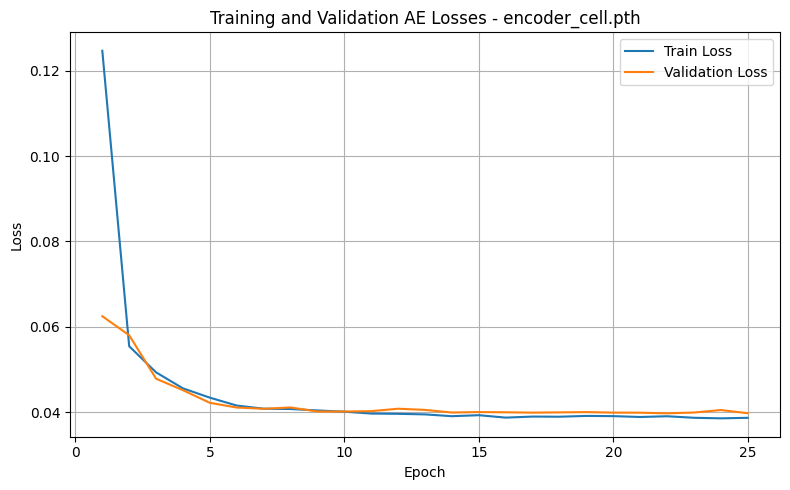

Fold 2
Epoch [1/25], Train Loss: 0.1306, Val Loss: 0.0669
Epoch [2/25], Train Loss: 0.0583, Val Loss: 0.0490
Epoch [3/25], Train Loss: 0.0500, Val Loss: 0.0443
Epoch [4/25], Train Loss: 0.0458, Val Loss: 0.0409
Epoch [5/25], Train Loss: 0.0428, Val Loss: 0.0411
Epoch [6/25], Train Loss: 0.0417, Val Loss: 0.0393
Epoch [7/25], Train Loss: 0.0408, Val Loss: 0.0396
Epoch [8/25], Train Loss: 0.0407, Val Loss: 0.0393
Epoch [9/25], Train Loss: 0.0408, Val Loss: 0.0391
Epoch [10/25], Train Loss: 0.0403, Val Loss: 0.0393
Epoch [11/25], Train Loss: 0.0400, Val Loss: 0.0389
Epoch [12/25], Train Loss: 0.0397, Val Loss: 0.0396
Epoch [13/25], Train Loss: 0.0399, Val Loss: 0.0393
Epoch [14/25], Train Loss: 0.0397, Val Loss: 0.0390
Epoch [15/25], Train Loss: 0.0393, Val Loss: 0.0391
Epoch [16/25], Train Loss: 0.0391, Val Loss: 0.0390
Epoch [17/25], Train Loss: 0.0393, Val Loss: 0.0385
Epoch [18/25], Train Loss: 0.0390, Val Loss: 0.0386
Epoch [19/25], Train Loss: 0.0393, Val Loss: 0.0382
Epoch [20/25],

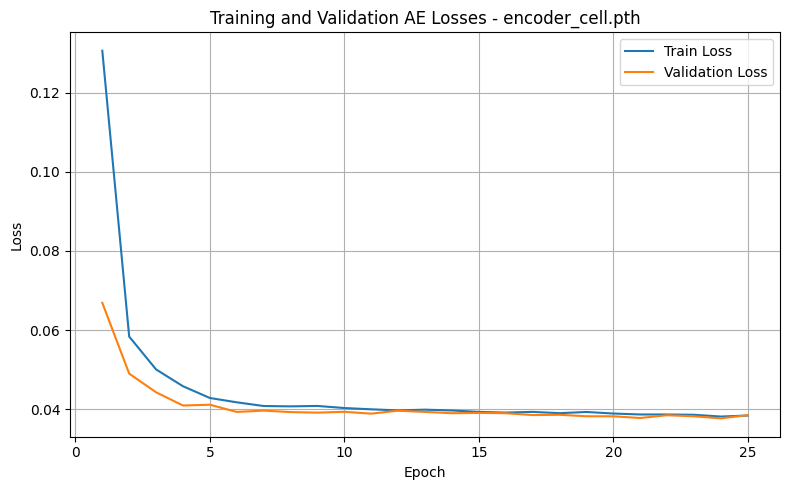

Fold 1
Epoch [1/25], Train Loss: 0.2496, Val Loss: 0.1995
Epoch [2/25], Train Loss: 0.1879, Val Loss: 0.1713
Epoch [3/25], Train Loss: 0.1746, Val Loss: 0.1684
Epoch [4/25], Train Loss: 0.1721, Val Loss: 0.1663
Epoch [5/25], Train Loss: 0.1683, Val Loss: 0.1651
Epoch [6/25], Train Loss: 0.1682, Val Loss: 0.1634
Epoch [7/25], Train Loss: 0.1655, Val Loss: 0.1622
Epoch [8/25], Train Loss: 0.1628, Val Loss: 0.1588
Epoch [9/25], Train Loss: 0.1592, Val Loss: 0.1564
Epoch [10/25], Train Loss: 0.1561, Val Loss: 0.1545
Epoch [11/25], Train Loss: 0.1546, Val Loss: 0.1524
Epoch [12/25], Train Loss: 0.1509, Val Loss: 0.1507
Epoch [13/25], Train Loss: 0.1482, Val Loss: 0.1489
Epoch [14/25], Train Loss: 0.1450, Val Loss: 0.1459
Epoch [15/25], Train Loss: 0.1417, Val Loss: 0.1437
Epoch [16/25], Train Loss: 0.1404, Val Loss: 0.1424
Epoch [17/25], Train Loss: 0.1378, Val Loss: 0.1418
Epoch [18/25], Train Loss: 0.1375, Val Loss: 0.1408
Epoch [19/25], Train Loss: 0.1359, Val Loss: 0.1396
Epoch [20/25],

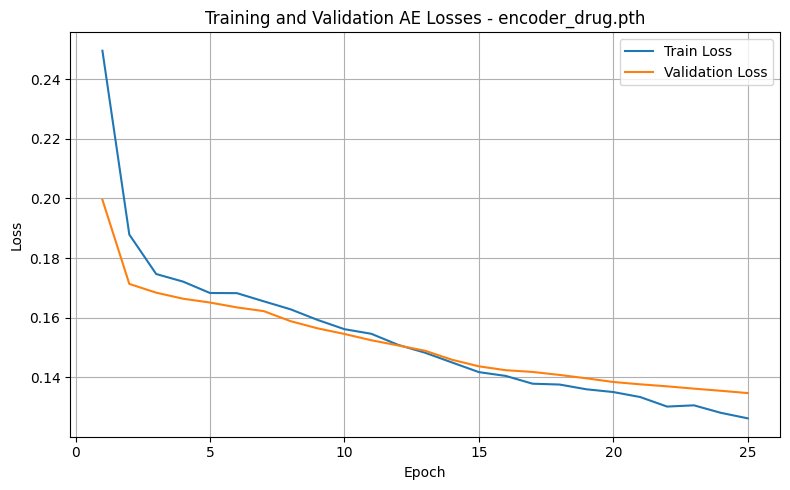

Fold 2
Epoch [1/25], Train Loss: 0.2517, Val Loss: 0.2025
Epoch [2/25], Train Loss: 0.1836, Val Loss: 0.1773
Epoch [3/25], Train Loss: 0.1706, Val Loss: 0.1759
Epoch [4/25], Train Loss: 0.1691, Val Loss: 0.1720
Epoch [5/25], Train Loss: 0.1674, Val Loss: 0.1695
Epoch [6/25], Train Loss: 0.1661, Val Loss: 0.1688
Epoch [7/25], Train Loss: 0.1649, Val Loss: 0.1682
Epoch [8/25], Train Loss: 0.1621, Val Loss: 0.1668
Epoch [9/25], Train Loss: 0.1606, Val Loss: 0.1650
Epoch [10/25], Train Loss: 0.1589, Val Loss: 0.1634
Epoch [11/25], Train Loss: 0.1579, Val Loss: 0.1622
Epoch [12/25], Train Loss: 0.1559, Val Loss: 0.1604
Epoch [13/25], Train Loss: 0.1525, Val Loss: 0.1589
Epoch [14/25], Train Loss: 0.1512, Val Loss: 0.1563
Epoch [15/25], Train Loss: 0.1497, Val Loss: 0.1547
Epoch [16/25], Train Loss: 0.1466, Val Loss: 0.1530
Epoch [17/25], Train Loss: 0.1450, Val Loss: 0.1513
Epoch [18/25], Train Loss: 0.1422, Val Loss: 0.1518
Epoch [19/25], Train Loss: 0.1412, Val Loss: 0.1497
Epoch [20/25],

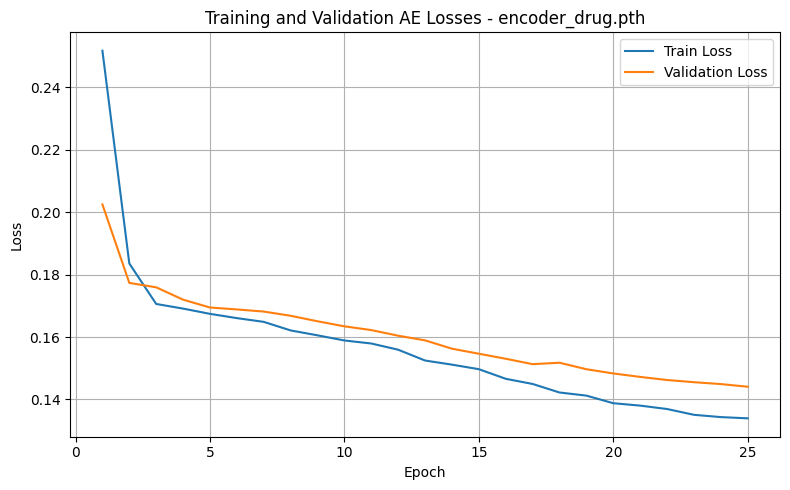

Sparsity z_cell: 0.0000, z_drug: 0.0000
z_cell std: 0.3033217787742615
z_drug std: 0.4705527424812317
z_cell shape: torch.Size([1355, 700])
z_drug shape: torch.Size([704, 50])


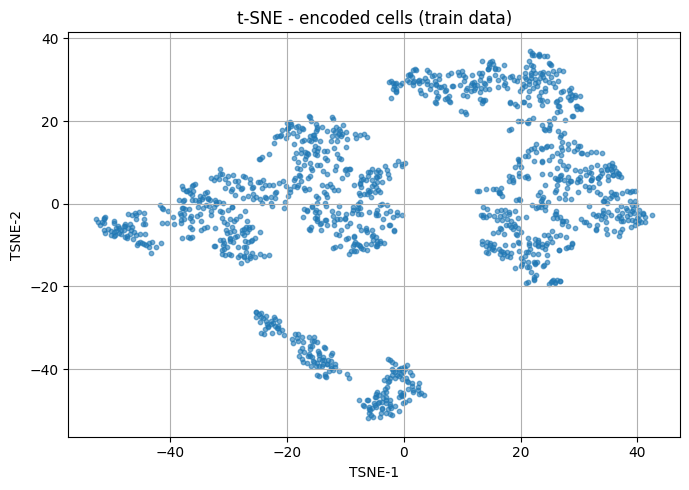

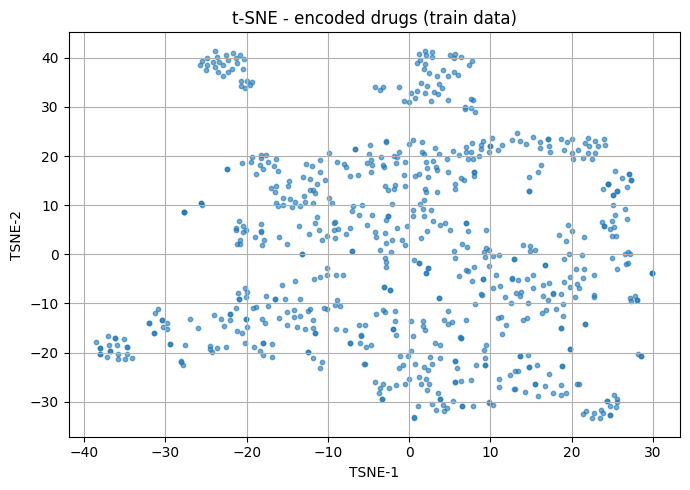

In [5]:
def run(k, is_test=False ):

    # Load raw data
    train_data, _ = RawDataLoader.load_data(data_modalities=DATA_MODALITIES,
                                            raw_file_directory=RAW_BOTH_DATA_FOLDER,
                                            screen_file_directory=None,
                                            sep="\t")

    print(train_data.keys())
    for key, df in train_data.items():
        print(f"{key}: {df.shape}")    

    # Load test data if applicable
    if is_test:
        test_data, _ = RawDataLoader.load_data(data_modalities=DATA_MODALITIES,
                                                raw_file_directory=TCGA_DATA_FOLDER,
                                                screen_file_directory=None,
                                                sep="\t")

        print(test_data.keys())
        for key, df in test_data.items():
            print(f"{key}: {df.shape}")
        
        train_data, test_data = RawDataLoader.data_features_intersect(train_data, test_data)


    # Prepare input data for training
    X_cell_train, X_drug_train, cell_train_sizes, drug_train_sizes = RawDataLoader.get_unique_entities(train_data)

    if is_test:
        X_cell_test, X_drug_test, cell_test_sizes, drug_test_sizes = RawDataLoader.get_unique_entities(test_data)

    print('x_cell_train shape:', X_cell_train.shape)
    print('x_drug_train shape:', X_drug_train.shape)

    if is_test:
        print('x_cell_test shape:', X_cell_test.shape)
        print('x_drug_test shape:', X_drug_test.shape)

    # Sparcity check
    print("X_cell_train sparsity:", (X_cell_train == 0).sum().sum() / X_cell_train.size)
    print("X_drug_train sparsity:", (X_drug_train == 0).sum().sum() / X_drug_train.size)
    
    if is_test:
        print("X_cell_test sparsity:", (X_cell_test == 0).sum().sum() / X_cell_test.size)
        print("X_drug_test sparsity:", (X_drug_test == 0).sum().sum() / X_drug_test.size)

    # plot t-SNE raw data
    plot_tsne(X_cell_train.values, "t-SNE on raw train data - cells")
    plot_tsne(X_drug_train.values, "t-SNE on raw train data - drugs")
    if is_test:
        plot_tsne(X_cell_test.values, "t-SNE on raw test data - cells")
        plot_tsne(X_drug_test.values, "t-SNE on raw test data - drugs")
    
    # Loop over k runs
    for i in range(k):
        print('Run {}'.format(i))

        if is_test:

            # Train and evaluate the reconstruction on test data
            ae_cell = train_autoencoder(X_cell_train, X_cell_test, cell_train_sizes, cell_test_sizes, 
                                        latent_dim=700, save_path="encoder_cell.pth", epochs=25, batch_size=64)
            ae_drug = train_autoencoder(X_drug_train, X_drug_test, drug_train_sizes, drug_test_sizes, 
                                        latent_dim=50, save_path="encoder_drug.pth", epochs=25, batch_size=64)

        else:
            # Train and evaluate the reconstruction on a train_test_split of the training dataset
            ae_cell = cv_train_autoencoder(X_train=X_cell_train, X_train_sizes=cell_train_sizes, 
                                           latent_dim=700, save_path="encoder_cell.pth", device=device, epochs=25, k=2, batch_size=64)
            ae_drug = cv_train_autoencoder(X_train=X_drug_train, X_train_sizes=drug_train_sizes, 
                                           latent_dim=50, save_path="encoder_drug.pth", device=device, epochs=25, k=2, batch_size=64)

        with torch.no_grad():
            
            x_cell_tensor = torch.tensor(X_cell_train.values, dtype=torch.float32).to(device)
            x_drug_tensor = torch.tensor(X_drug_train.values, dtype=torch.float32).to(device)
            
            _, z_cell = ae_cell(x_cell_tensor, return_latent=True)
            _, z_drug = ae_drug(x_drug_tensor, return_latent=True)

        sparsity_cell = (z_cell == 0).float().mean().item()
        sparsity_drug = (z_drug == 0).float().mean().item()
        print(f"Sparsity z_cell: {sparsity_cell:.4f}, z_drug: {sparsity_drug:.4f}")

        print("z_cell std:", z_cell.std().item())
        print("z_drug std:", z_drug.std().item())

        print("z_cell shape:", z_cell.shape)
        print("z_drug shape:", z_drug.shape)

        # Visualisation t-SNE latent space
        plot_tsne(z_cell.detach().cpu().numpy(), "t-SNE - encoded cells (train data)")
        plot_tsne(z_drug.detach().cpu().numpy(), "t-SNE - encoded drugs (train data)")


if __name__ == "__main__":
    torch.manual_seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    run(1, is_test=False)
    